In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch

import matplotlib.pyplot as plt
import pickle

from seamf import trace


data_path = Path('data')

# plt.rc('font',**{'family':'serif','serif':['Times New Roman']})
# plt.rc('lines', linewidth=1)
plt.style.use('ieee-publication-enlarged.mplstyle')
# %config InlineBackend.figure_formats = ['svg']

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [11]:
from ziparchive import read_seamf_zipfile_as_ddf, restore_multiindex
import dask

partition_size = 100

# Generated the pickle by loading from the zipfile as follows:
with stopwatch():
    ddfs = read_seamf_zipfile_as_ddf(data_path/'NIT-2022-12-13.zip', partition_size=partition_size)

    day_ddfs = {
        k: ddfs[k].loc['2022-11-01']
        for k in ('psd', 'pfp', 'pvt', 'channel_metadata')
    }

    day = dask.compute(day_ddfs, num_workers=8)[0]
    restore_multiindex(day)

    for table_name in ('psd', 'pfp', 'pvt'):
        day[table_name] = day[table_name].astype('float32')

 INFO   2023-03-13 12:18:38.107 • labbench: 13.642 s elapsed


<AxesSubplot: xlabel='datetime', ylabel='Channel power (dBm/10 MHz)'>

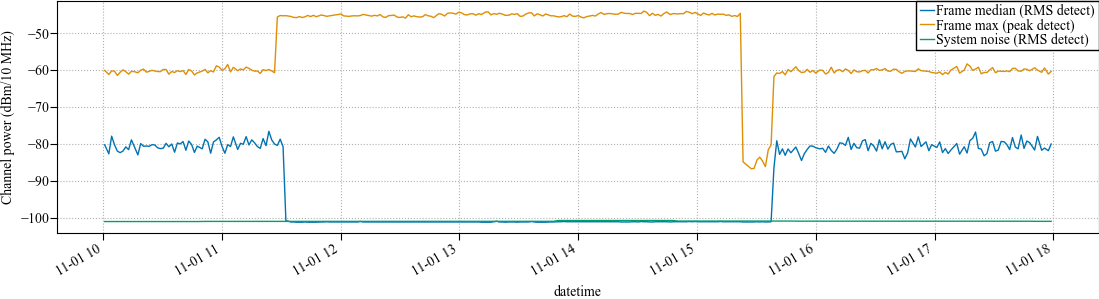

In [12]:
freq = 3605e6

pfp_indicators = {
    'Frame median (RMS detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='mean', detector='rms').quantile(0.5, axis=1),
    'Frame max (peak detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='max', detector='peak').max(axis=1),
    'System noise (RMS detect)':
        trace(day, 'channel_metadata', 'cal_noise_figure_dB', frequency=freq) + -174 + 70 - 1
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

fig, ax = plt.subplots(figsize=(11,3))
(
    pfp_indicators.loc['2022-11-01 10:00:00':'2022-11-01 18:00:00']
    .plot(ax=ax, ylabel='Channel power (dBm/10 MHz)')
)

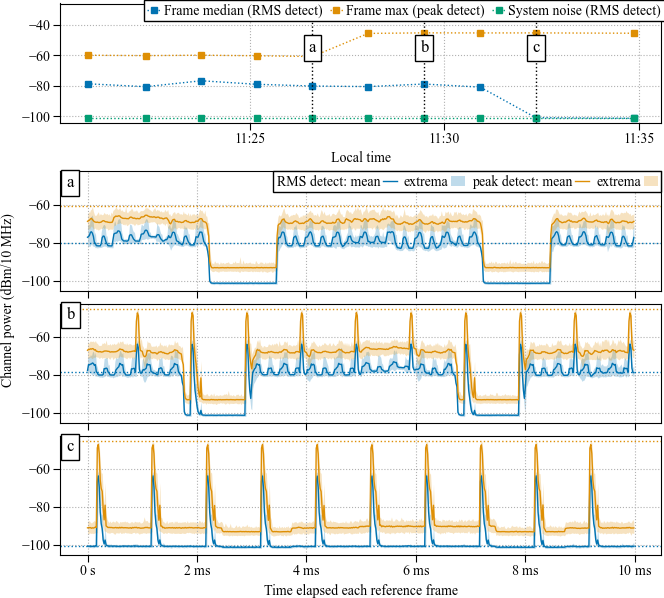

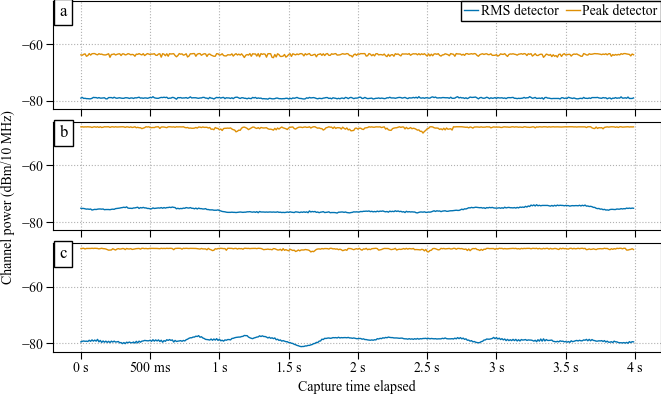

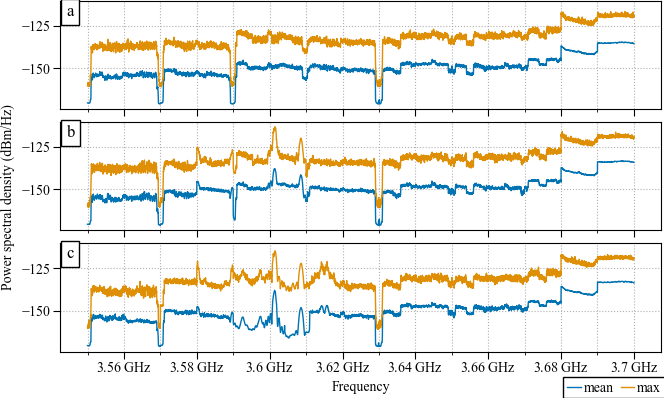

In [22]:
from plots import nearest_datetimes, plot_pfp_span_with_detail, plot_pvt_detail, plot_psd_detail

plt.style.use('report.mplstyle')

detail_trace_targets = {'a': '2022-11-01 11:26', 'b': '2022-11-01 11:30', 'c': '2022-11-01 11:33'}
mid_span = slice('2022-11-01 11:20:00','2022-11-01 11:35:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_start.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes)
fig.savefig('nit_event_2022-11_pvt_start.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_start.svg')

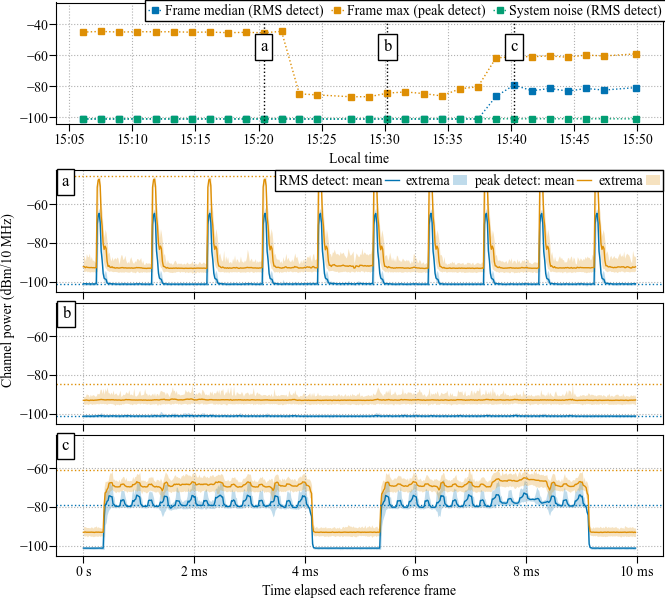

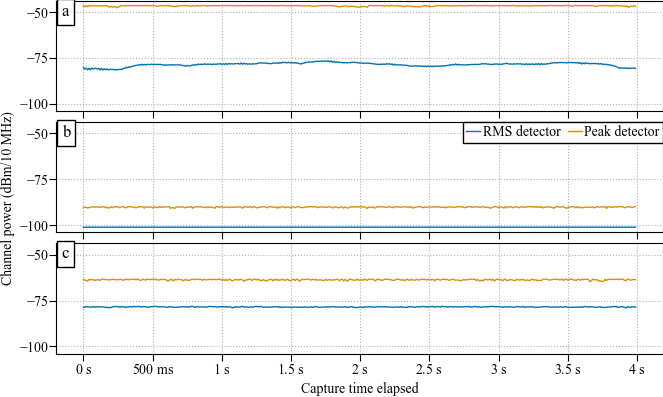

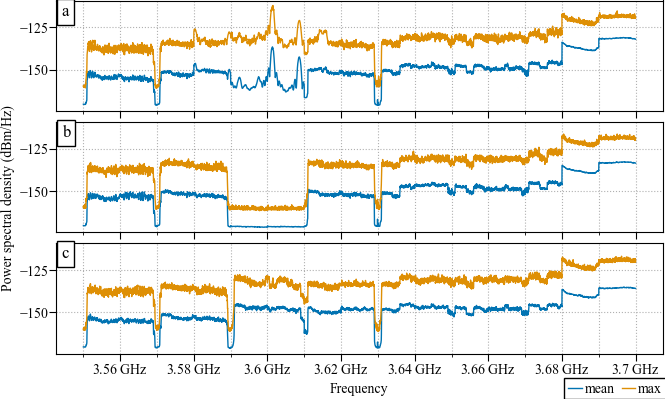

In [19]:
detail_trace_targets = {'a': '2022-11-01 15:20', 'b': '2022-11-01 15:30', 'c': '2022-11-01 15:40'}
mid_span = slice('2022-11-01 15:05:00','2022-11-01 15:50:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_end.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=1)
plt.savefig('nit_event_2022-11_pvt_end.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_end.svg')